# Web scraping

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

### Description  
One of the applications that rises frequently in machine learning projects is classification. A sector where intensively uses classification is retrieval on large data banks mostly by using queries on the previously categorized data. For example, indexing in search engines helps fast retrieval of relevant data, or in e-commerce platforms, appropriate categorization and placement of filters is necessary for better user experience. It allows customers to access their relevant goods with ease, making the platform more profitable.  


### Information  

In [ ]:
full_name = 'Ali Soleimani Aramideh'

## 1 Retrieval of Data

Consider a content delivery website. On the user end, when you want to find what you want in such websites, you probably use the search bar or the navigation menu on the top, or alternatively, let Google find you the best matching result using its proprietary indexing (which by the way, usually works better than the website's own search bar!).  

But as a data engineer, the level of detail and comprehensiveness of data matters more as you are looking for insight rather than single matches. It allows you to analyze different aspects of social behavior on different localities and make informed decisions based on that.  

Consider that you are a data analyst for a software team given the task of analyzing market demand for your upcoming product. In this scenario, one of the best ways is to track activity on forums and goto places where people get their software from. This can range from different online stores and websites, to community forums and related social media posts.  

After discussion, you have found that `downloadha.com` is one of the main sources local people use for downloading their software hence you want to analyze the demand for different categories of softwares.

### 1.1 Crawling

List the information related to each software for the last 1000 softwares listed on the mentioned website. The website uses pagination with 10 results available on each page. So for reaching 1000 softwares you need to crawl `downloadha.com/page/1/` up to `downloadha.com/page/100/`. For having a safety threshold in case of crawler failure (a common problem in crawlers), you can extend it to 2000 items to be sure you are left with 1000 decent instances.  

This website is chosen in particular for its easy access to database. Remember that as systems gets more advanced accessing older data becomes harder. For comparison try to search for books that were listed on Amazon before 2020 and look at the URL!  

The data for each software should include:
- Name
- Platform
- Category and Subcategories
- Description
- Date of Creation
- Author
- Visit Count
- Comment Count
- Tags

Save the data on a CSV file and upload it with your delivery. You can use libraries like Beautiful Soup and Scrapy for the crawling task.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
# Needed functions
import re

def extract_game_name_and_platform(url):
    # Extract the part of the URL that contains the game name and platform
    match = re.search(r'/game/(.+?)-(\w+)/?$', url)
    if match:
        # Replace hyphens with spaces and title case the name
        game_name = match.group(1).replace('-', ' ').title()
        platform = match.group(2).upper()  # Convert platform to uppercase
        return game_name, platform
    else:
        return "Could not extract info", "Unknown"

def extract_author(url):
    if not url.startswith('https://www.downloadha.com/author/'):
        return "Invalid URL format for author extraction."

    parts = url.rstrip('/').split('/')
    author_name = parts[-1]  # The author's name is the last part of the URL
    return author_name

def extract_visit_count(text):
    # Extract digits, including commas
    match = re.search(r'[\d,]+', text)
    if match:
        # Remove commas and convert to integer
        numeric_part = match.group().replace(',', '')
        return int(numeric_part)
    else:
        return None

def convert_persian_numbers_to_english(persian_number):
    persian_numerals = '۰۱۲۳۴۵۶۷۸۹'
    english_numerals = '0123456789'
    translation_table = str.maketrans(persian_numerals, english_numerals)
    return persian_number.translate(translation_table)

def extract_comment_count(text):
    if 'بدون نظر' in text:
        return 0
    else:
        # Extract Persian numbers
        match = re.search(r'[\d۰۱۲۳۴۵۶۷۸۹]+', text)
        if match:
            persian_number = match.group()
            return int(convert_persian_numbers_to_english(persian_number))
        else:
            return None

def extract_tags(text):
    # Remove the initial part of the string ("برچسب ها:" or "برچسب‌ها:")
    clean_text = text.replace('برچسب ها:', '').replace('برچسب‌ها:', '').strip()
    # Split the tags by comma
    tags = clean_text.split(', ')
    return tags

In [ ]:
all_articles = []

for i in range(1, 301):
    url = f"https://www.downloadha.com/page/{i}/"
    response = requests.get(url=url)
    response = response.content
    soup = BeautifulSoup(response, 'html.parser')
    main = soup.find('main')
    articles = main.find_all('article')
    for article in articles:
        title_element = article.find('h2', class_="entry-title")
        url = title_element.find('a')['href'] if title_element and title_element.find('a') else "URL not found"
        name, platform = extract_game_name_and_platform(url)

        dirty_categories = article.find_all('a', rel="category tag")
        categories = [category.get_text() for category in dirty_categories if category]

        description_element = article.find('p', style='text-align: justify;')
        description = description_element.text if description_element else "Description not available"

        footer = article.find('footer')
        if footer:
            time_element = footer.find('time', class_='entry-date published')
            time = time_element.text if time_element else "Time not available"

            author_url_element = footer.find('a', class_='url fn n')
            author_url = author_url_element['href'] if author_url_element else "Author URL not found"
            author = extract_author(author_url)

            visit_count_element = footer.find('div', class_='post-view inline-block')
            visit_count_dirty = visit_count_element.text if visit_count_element else "0"
            visit_count = extract_visit_count(visit_count_dirty)

            comment_count_elements = footer.find_all('div', class_='post-view inline-block')
            comment_count_dirty = comment_count_elements[1].text if len(comment_count_elements) > 1 else "0"
            comment_count = extract_comment_count(comment_count_dirty)

            tags_dirty = footer.find('div', class_="post-tags")
            tags = extract_tags(tags_dirty.text) if tags_dirty else []

        article_data = {
            'Title': name,
            'Platform': platform,
            'Categories': categories,
            'Description': description,
            'Publication Time': time,
            'Author': author,
            'Visit Count': visit_count,
            'Comment Count': comment_count,
            'Tags': tags
        }
        all_articles.append(article_data)


In [ ]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_articles)

# Define the CSV file name
csv_file = "softwares_data.csv"

# Write to CSV
df.to_csv(csv_file, index=False, encoding='utf-8')
print(f"Data written to {csv_file}")

Data written to softwares_data.csv


In [ ]:
df.shape

(3000, 9)

### 1.2 Database (Bonus)  
Use a relational database like MySQL, SQLite or a non-relational instance like MongoDB for archiving the data. You don't need online implementation of this and can create a local instance of database and upload the relevant files with your delivery.

In [ ]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('games_data.db')
cursor = conn.cursor()

# Create a table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS games (
        Title TEXT,
        Platform TEXT,
        Categories TEXT,
        Description TEXT,
        PublicationTime TEXT,
        Author TEXT,
        VisitCount INTEGER,
        CommentCount INTEGER,
        Tags TEXT
    )
''')
conn.commit()

# Read data from CSV
df = pd.read_csv('softwares_data.csv')

# Convert lists in 'Categories' and 'Tags' columns to strings
df['Categories'] = df['Categories'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) else x)
df['Tags'] = df['Tags'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) else x)

# Write data to SQLite database
df.to_sql('games', conn, if_exists='replace', index=False)

# Example: Select all records
cursor.execute('SELECT * FROM games')
rows = cursor.fetchall()

for row in rows:
    print(row)

conn.close()

('Lost', 'ARK', 'بازی آنلاین رایگان, بازی اکشن, بازی کامپیوتر, نقش آفرینی', 'بازی Lost Ark در دنیایی وسیع و پر اتفاقات هیجان انگیز دنبال می\u200cشود. وظیفه شما راه\u200cاندازی ادیسه\u200cای برای پیدا کردن یک کشتی گمشده است. باید به سراغ سرزمین\u200cهای جدید رفته و گنج\u200cهای گمشده را پیدا کنید. سبک مبارزه خود را انتخاب کرده و رفته رفته آن را ارتقا دهید. شما می\u200cتوانید کلاس بندی مبارزات خود را رفته رفته ارتقا داده و به مهارت\u200cها و سلاح\u200cهای جدیدی دست پیدا کنید. باید تجهیزات خود را پیشرفت داده و به قدرت\u200cهای بالایی در زمینه مبارزه با دشمنان خود دست پیدا کنید. باس\u200cهای عظیم الجثه و جالبی را می\u200cبینیم که به عنوان نیروهای تاریکی به\u200cدنبال رسیدن به قدرت و مقام در این سرزمین هستند.', '۱۴۰۲/۱۱/۰۸', 'hosein', 60945, 85.0, 'بازی AAA, دانلود Lost Ark, دانلود بازی Lost Ark, دانلود بازی Lost Ark برای کامپیوتر, دانلود بازی Lost Ark کرک شده, دانلود بازی کامپیوتر Lost Ark')
('Pc Efootball', '2022', 'بازی کامپیوتر, بازی ورزشی, شبیه سازی', 'با بازی eFootball 2024 دوران جدید

## 2 Exploratory Data Analysis

Report the information about the data in charts. This includes converting the data into a consistent format, including the dates, descriptions, etc.  

More attention needs to be put toward the default categorization the website has provided. As it is given in a breadcrumb format, you need to breakdown the category to extract different levels. You need to deliver the following data/visualizations for this part:

- Graph of different categories and subcategories of the softwares available on the website. Some of the material listed might not be software but videos. For those, use the default category of the website to create a new section. **Treat videos, educational packages, etc. just as other categories of software. Do not exclude them from the data.**

In [ ]:
# Split the 'Categories' column into a list of categories
df['Categories'] = df['Categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

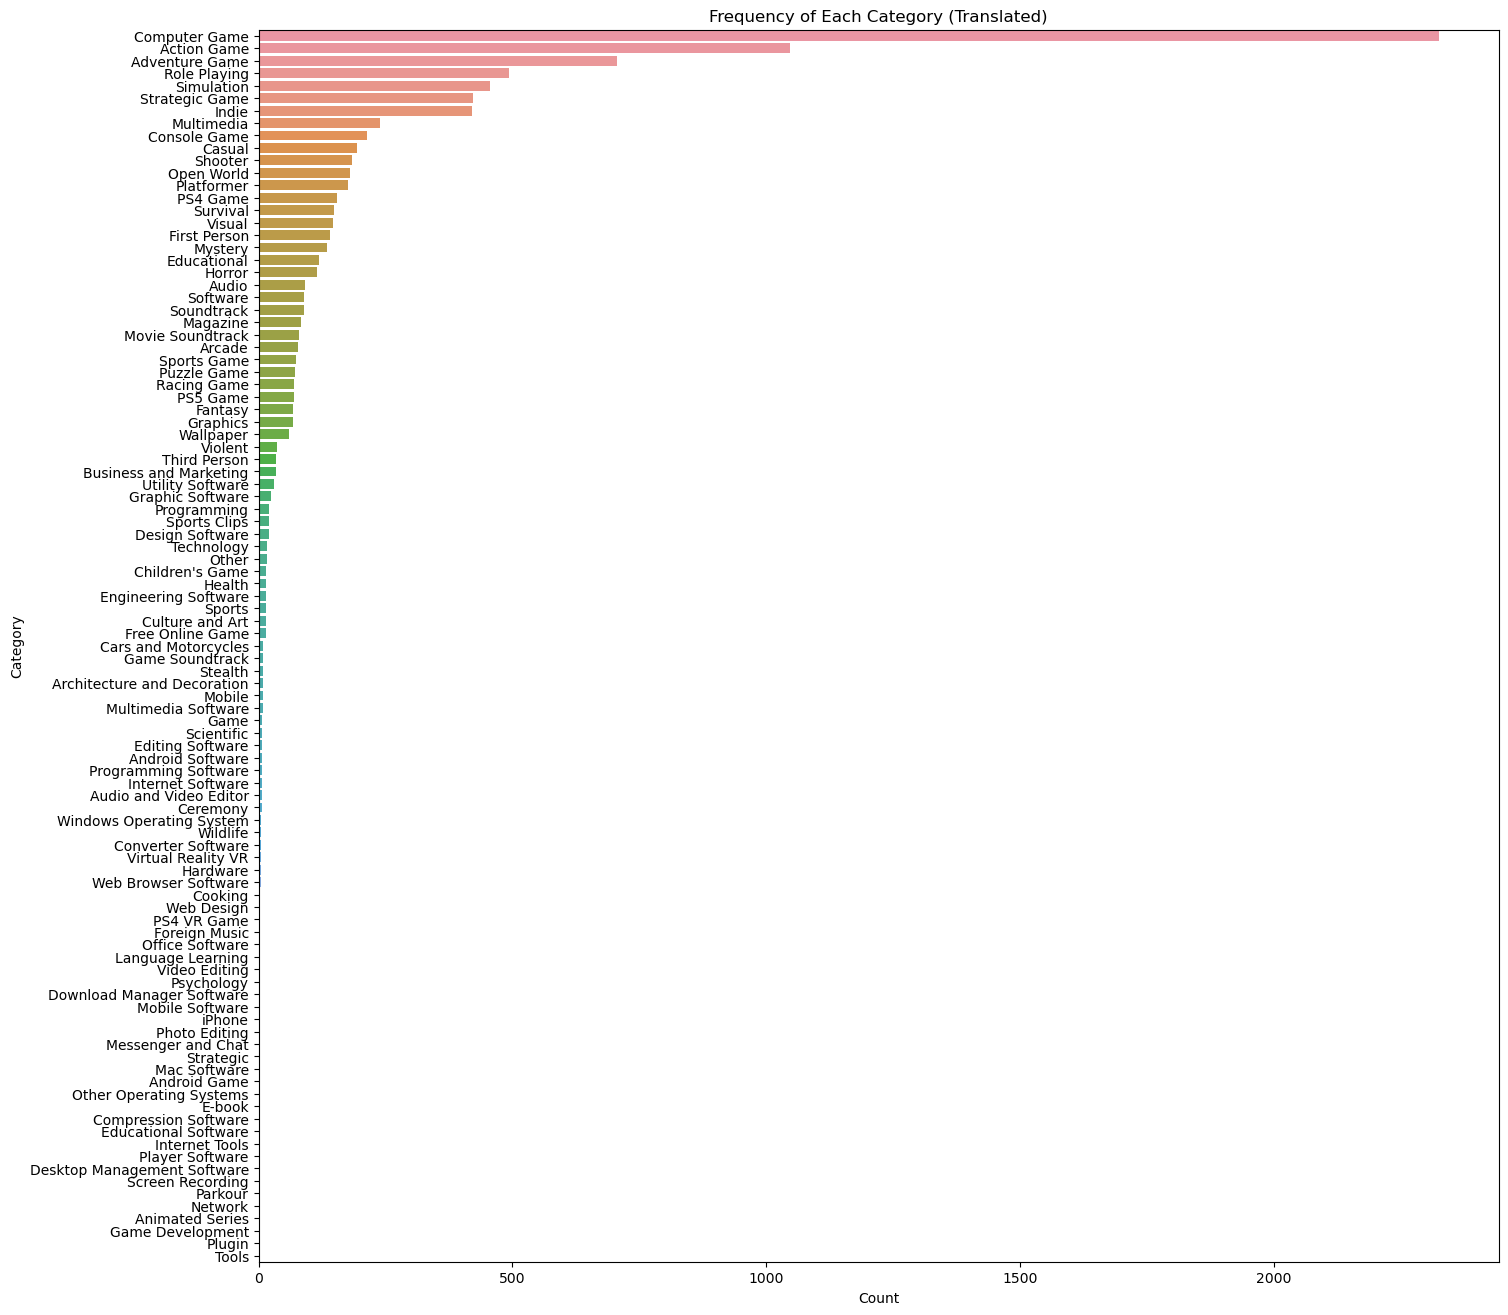

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = df

# Translation of Persian categories into English
category_translation = {
    'آرکید': 'Arcade',
    'آشپزی': 'Cooking',
    'آموزش زبان': 'Language Learning',
    'آموزشی': 'Educational',
    'آیفون': 'iPhone',
    'ابزار اینترنت': 'Internet Tools',
    'ابزارها': 'Tools',
    'استراتژیک': 'Strategic',
    'انیمیشن سریالی': 'Animated Series',
    'اول شخص': 'First Person',
    'ایندی': 'Indie',
    'بازی': 'Game',
    'بازی PS4': 'PS4 Game',
    'بازی PS4 VR': 'PS4 VR Game',
    'بازی PS5': 'PS5 Game',
    'بازی آنلاین رایگان': 'Free Online Game',
    'بازی استراتژیک': 'Strategic Game',
    'بازی اندروید': 'Android Game',
    'بازی اکشن': 'Action Game',
    'بازی فکری': 'Puzzle Game',
    'بازی ماجرایی': 'Adventure Game',
    'بازی ماشین سواری': 'Racing Game',
    'بازی ورزشی': 'Sports Game',
    'بازی کامپیوتر': 'Computer Game',
    'بازی کنسول': 'Console Game',
    'بازی کودکان': 'Children\'s Game',
    'برنامه نویسی': 'Programming',
    'تجارت و بازاریابی': 'Business and Marketing',
    'ترسناک': 'Horror',
    'تصویری': 'Visual',
    'تلاش برای بقا': 'Survival',
    'تکنولوژی': 'Technology',
    'جهان آزاد': 'Open World',
    'حیات وحش': 'Wildlife',
    'خشونت آمیز': 'Violent',
    'خودرو و موتور': 'Cars and Motorcycles',
    'روانشناسی': 'Psychology',
    'ساخت بازی': 'Game Development',
    'سایر': 'Other',
    'سایر سیستم عامل ها': 'Other Operating Systems',
    'سخت افزار': 'Hardware',
    'سلامت': 'Health',
    'سوم شخص': 'Third Person',
    'سیستم عامل ویندوز': 'Windows Operating System',
    'شبکه': 'Network',
    'شبیه سازی': 'Simulation',
    'شوتر': 'Shooter',
    'صوتی': 'Audio',
    'ضبط صفحه نمایش': 'Screen Recording',
    'طراحی وب': 'Web Design',
    'علمی': 'Scientific',
    'فانتزی': 'Fantasy',
    'فرهنگ و هنر': 'Culture and Art',
    'مالتی مدیا': 'Multimedia',
    'مجله': 'Magazine',
    'مخفی کاری': 'Stealth',
    'مراسم': 'Ceremony',
    'مسنجر و پیغام رسان': 'Messenger and Chat',
    'معماری و دکوراسیون': 'Architecture and Decoration',
    'معمایی': 'Mystery',
    'موبایل': 'Mobile',
    'موزیک خارجی': 'Foreign Music',
    'موسیقی متن': 'Soundtrack',
    'موسیقی متن بازی': 'Game Soundtrack',
    'موسیقی متن فیلم': 'Movie Soundtrack',
    'نرم افزار': 'Software',
    'نرم افزار آفیس': 'Office Software',
    'نرم افزار آموزشی': 'Educational Software',
    'نرم افزار اندروید': 'Android Software',
    'نرم افزار اینترنت': 'Internet Software',
    'نرم افزار برنامه نویسی': 'Programming Software',
    'نرم افزار تبدیل کننده': 'Converter Software',
    'نرم افزار طراحی': 'Design Software',
    'نرم افزار فشرده ساز': 'Compression Software',
    'نرم افزار مالتی مدیا': 'Multimedia Software',
    'نرم افزار مبدل': 'Converter Software',
    'نرم افزار مدیریت دانلود': 'Download Manager Software',
    'نرم افزار مدیریت دسکتاپ': 'Desktop Management Software',
    'نرم افزار مرورگر وب': 'Web Browser Software',
    'نرم افزار مهندسی': 'Engineering Software',
    'نرم افزار موبایل': 'Mobile Software',
    'نرم افزار ویرایشگر': 'Editing Software',
    'نرم افزار پخش کننده': 'Player Software',
    'نرم افزار کاربردی': 'Utility Software',
    'نرم افزار گرافیک': 'Graphic Software',
    'نرم افزارهای مک': 'Mac Software',
    'نقش آفرینی': 'Role Playing',
    'واقعیت مجازی VR': 'Virtual Reality VR',
    'والپیپر': 'Wallpaper',
    'ورزشی': 'Sports',
    'ویرایش عکس': 'Photo Editing',
    'ویرایش فیلم': 'Video Editing',
    'ویرایشگر صوت و تصویر': 'Audio and Video Editor',
    'پارکور': 'Parkour',
    'پلاگین': 'Plugin',
    'پلتفرمر': 'Platformer',
    'کتاب الکترونیک': 'E-book',
    'کلیپ های ورزشی': 'Sports Clips',
    'کژوال': 'Casual',
    'گرافیک': 'Graphics'
}


# Translate categories in the dataset
translated_categories = []
for categories_list in data['Categories']:
    translated_list = [category_translation.get(cat, cat) for cat in categories_list]
    translated_categories.extend(translated_list)

# Count the frequency of each translated category
translated_category_counts = pd.Series(translated_categories).value_counts()

# Creating a bar plot for translated category frequencies
plt.figure(figsize=(16, 16))
sns.barplot(x=translated_category_counts.values, y=translated_category_counts.index)
plt.title('Frequency of Each Category (Translated)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


In [ ]:
translated_categories = []
for categories_list in data['Categories']:
    translated_list = [category_translation.get(cat, cat) for cat in categories_list]
    translated_categories.append(translated_list)

# Create a new column for the translated categories
data['Categories (English)'] = translated_categories

# Drop the original Persian 'Categories' column
data.drop('Categories', axis=1, inplace=True)

- Frequency of softwares provided for different platforms and operating systems including but not limited to PS5, Windows, Linux, MacOS X.

In [ ]:
data['Platform']

0           ARK
1          2022
2            PC
3            PC
4           PS5
         ...   
2995    Unknown
2996    MATTERS
2997         PC
2998      SQUAD
2999       PAIN
Name: Platform, Length: 3000, dtype: object

In [ ]:
data.to_csv('Data.csv', index=False, encoding='utf-8')

In [ ]:
platform_keywords = {
    'PC': ['Computer Game', 'Compression Software'],
    'iOS': ['iPhone'],
    'PS5': ['PS5 Game'],
    'Console': ['Console Game'],
    'Android': ['Android Game', 'Android Software'],
    'Mac': ['Mac Software', 'MacOS'],
    'Linux': ['Linux'],
    'PS4': ['PS4 VR Game', 'PS4 Game'],
    'mobile': ['Mobile Software']
}

# Function to determine the platform based on categories
def determine_platform(categories_str):
    if isinstance(categories_str, str):
        categories = eval(categories_str)
    else:
        categories = categories_str  # Assuming it's already a list if not a string

    for platform, keywords in platform_keywords.items():
        if any(keyword in categories for keyword in keywords):
            return platform
    return 'Other'  # Default value if no platform-specific keyword is found

# Apply the function to clean the 'Platform' column
data['Platform'] = data['Categories (English)'].apply(determine_platform)

# Display the first few rows of the updated dataset
data

Title Platform  \
0                               Lost       PC   
1                       Pc Efootball       PC   
2               Marvels Spider Man 2       PC   
3                           Tekken 8       PC   
4     Dungeons Dragons Dark Alliance      PS5   
...                              ...      ...   
2995          Could not extract info       PC   
2996                    Gunborg Dark       PC   
2997      Warhammer 40000 Space Wolf       PC   
2998                    Ryans Rescue       PC   
2999   Roccos Island Ring To End The       PC   

                                            Description Publication Time  \
0     بازی Lost Ark در دنیایی وسیع و پر اتفاقات هیجا...       ۱۴۰۲/۱۱/۰۸   
1     با بازی eFootball 2024 دوران جدیدی از شبیه‌ساز...       ۱۴۰۲/۱۱/۰۷   
2     بازی Marvel’s Spider-Man 2 دنباله‌ای شایسته بر...       ۱۴۰۲/۱۱/۰۷   
3     بازی Tekken 8 (تکن ۸) توسط بندای نامک توسعه یا...       ۱۴۰۲/۱۱/۰۷   
4     بازی Dungeons and Dragons Dark Alliance شما را...       ۱۴۰۲/۱۱/۰۷   
...                                                 ...              ...   
2995  داستان بازی MeteoHeroes پیرامون ۶ کاراکتر کودک...       ۱۴۰۰/۱۲/۱۷   
2996  بازی Gunborg Dark Matters یک تجربه اکشن و پلتف...       ۱۴۰۰/۱۲/۱۷   
2997  بازی Warhammer 40000 Space Wolf فرماندهی یک جو...       ۱۴۰۰/۱۲/۱۷   
2998  در بازی Ryans Rescue Squad خواهیم دید که دوستا...       ۱۴۰۰/۱۲/۱۷   
2999  داستان بازی Roccos Island Ring to End the Pain...       ۱۴۰۰/۱۲/۱۷   

      Author  Visit Count  Comment Count  \
0     hosein        60945           85.0   
1     behnam       394572          141.0   
2     behnam         7298           25.0   
3     hosein        21672           76.0   
4     behnam          345            0.0   
...      ...          ...            ...   
2995  behnam          589            0.0   
2996  behnam         2239            0.0   
2997  behnam         2975            0.0   
2998  behnam          375            0.0   
2999  behnam          762            0.0   

                                                   Tags  \
0     [بازی AAA, دانلود Lost Ark, دانلود بازی Lost A...   
1     [بازی AAA, دانلود eFootball 2022, دانلود PES 2...   
2     [بازی AAA, دانلود اسپایدرمن 2 برای pc, دانلود ...   
3     [بازی AAA, دانلود TEKKEN 8 برای کامپیوتر, دانل...   
4     [دانلود Dungeons Dragons Dark Alliance برای پی...   
...                                                 ...   
2995  [دانلود MeteoHeroes, دانلود بازی MeteoHeroes, ...   
2996  [دانلود Gunborg Dark Matters, دانلود بازی Gunb...   
2997  [بازی AAA, دانلود Warhammer 40000 Space Wolf, ...   
2998  [دانلود Ryans Rescue Squad, دانلود بازی Ryans ...   
2999  [دانلود Roccos Island Ring to End the Pain, دا...   

                                   Categories (English)  
0     [Free Online Game, Action Game, Computer Game,...  
1              [Computer Game, Sports Game, Simulation]  
2              [Action Game, Computer Game, Open World]  
3                  [Arcade, Action Game, Computer Game]  
4                              [PS5 Game, Console Game]  
...                                                 ...  
2995  [Arcade, Action Game, Computer Game, Adventure...  
2996       [Arcade, Computer Game, Platformer, Shooter]  
2997      [Strategic Game, Computer Game, Role Playing]  
2998            [Computer Game, Adventure Game, Casual]  
2999           [Computer Game, Adventure Game, Mystery]  

[3000 rows x 9 columns]

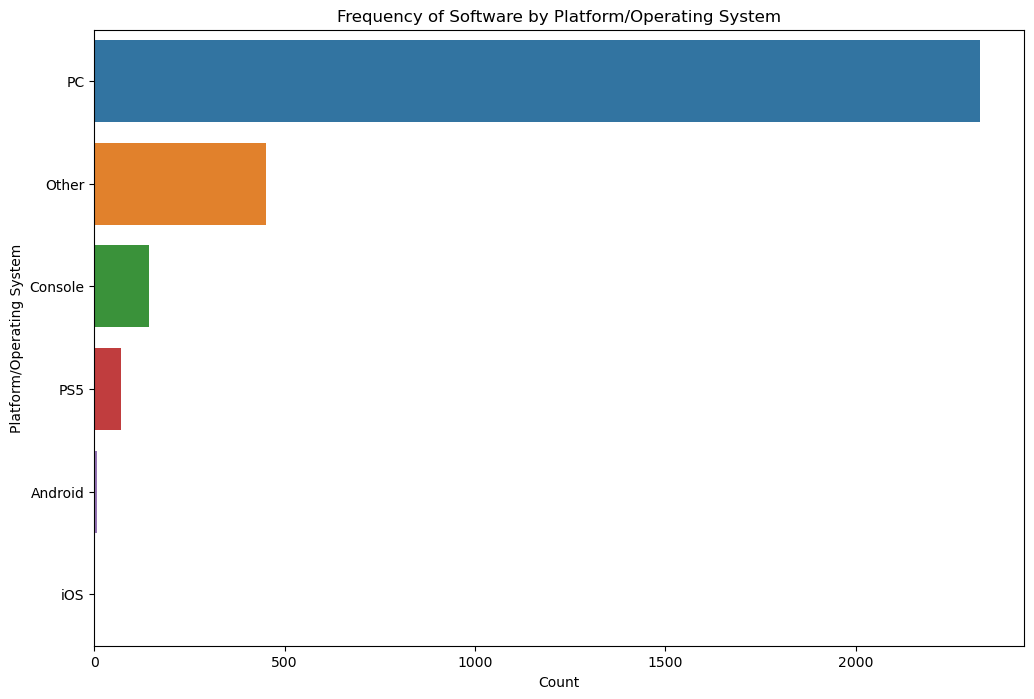

In [ ]:
# Counting the frequency of each platform
platform_counts = data['Platform'].value_counts()

# Creating a bar plot for platform frequencies
plt.figure(figsize=(12, 8))
sns.barplot(x=platform_counts.values, y=platform_counts.index)
plt.title('Frequency of Software by Platform/Operating System')
plt.xlabel('Count')
plt.ylabel('Platform/Operating System')
plt.show()